# 0. 패키지 불러오기

In [ ]:
!pip install catboost
!pip install category_encoders
!pip install optuna

     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 82 kB 345 kB/s 
     |████████████████████████████████| 308 kB 4.0 MB/s 
     |████████████████████████████████| 209 kB 70.9 MB/s 
     |████████████████████████████████| 80 kB 8.4 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 62.0 MB/s 
     |████████████████████████████████| 149 kB 78.0 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e3e6f66e583da44541ca7f0e259ed17f2fa3ac1caf85f375ee10dfe782a9c4a5
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # matplotlib의 font_manager에서 폰트설정을 변경하여 matplotlib에서도 한글 출력을 가능하게 한다.
import seaborn as sns

from sklearn.ensemble import * # ExtraTreesRegressor, RandomForestClassifier
from sklearn.model_selection import * # KFold, cross_val_score, train_test_split
from sklearn.metrics import *  # make_scorer : MSE 대신 사용자가 정의한 손실함수를 사용하고 싶을 때
from sklearn.preprocessing import * # LabelEncoder, StandardScaler
from sklearn.svm import * # SVC, SVR
from sklearn.inspection import *
from sklearn.linear_model import * # LogisticRegression, RANSACRegressor, Ridge, Lasso, ElasticNet
from sklearn.decomposition import * # PCA

from category_encoders.ordinal import OrdinalEncoder
from catboost import CatBoostClassifier, Pool
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from lightgbm import *
import lightgbm as lgb
import xgboost as xgb
from datetime import datetime
import calendar
import warnings
warnings.filterwarnings(action = 'ignore') # 경고메세지를 무시하거나 숨긴다.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData"

In [ ]:
Rdata_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/train2.csv')
Rdata_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/test2.csv')
Rdata_D = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/속성_D_코드.csv', index_col = 0).T.to_dict()
Rdata_H = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/속성_H_코드.csv', index_col = 0).T.to_dict()
Rdata_L = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/속성_L_코드.csv', index_col = 0).T.to_dict()
print(Rdata_train.shape)
print(Rdata_train.size)
print(Rdata_test.shape)
print(Rdata_test.size)
Rdata_train.head()

In [ ]:
df_train = Rdata_train.copy()
df_test = Rdata_test.copy()
df_D = Rdata_D.copy()
df_H = Rdata_H.copy()
df_L = Rdata_L.copy()

In [ ]:
df_train.info()

In [ ]:
df_test.info()

# 2. 범주형 encoding

In [ ]:
df_train.dtypes.value_counts()

int형에 속하는 컬럼들에 특징 값 분포
*   특징 값 분포를 통해서 Label Encoding과 Ont-Hot Encoding 방식을 결정
*   가장 많은 특징 값을 갖는 것이 'person_rn' -> 300177


*   동일한 특징 값을 갖는 특징들은 ['person_prefer_f', 'person_prefer_g', 'Y'] 라는 것을 파악 ->  이 변수들은 볼 필요가 없다.
  *   모든 값에 대해서 동일한 값을 갖는 것을 주목해야 한다.
  *   이러한 특징 값들은 추후 모델 학습에서 Drop 시키고 학습을 실시 하겠습니다.

Ont-Hot Encoding
1. 순서가 없을 때 (ex. 국가명)
2. 고유값의 개수가 많지 않으면 효율적

Label Encoding
1. 순서의 의미가 있을때 (유치원, 초등학교, 대학교 같은 등급, 사원, 대리, 과장, 부장 같은 직급?? )
2. 고유값의 개수가 많을때 (One-hot Encoding은 당연히 메모리 소비가 많으므로 효율적이진 못하다. )
3. 선형 회귀와 같은 ML알고리즘에는 적용 불가
4. 트리 계열의 ML 알고리즘은 숫자의 이러한 특성을 반영하지 않으므로 가능
5. LabelEncoder는 dataframe의 열마다 접근해야 한다.

In [ ]:
df_train.select_dtypes('int64').apply(pd.Series.nunique, axis = 0)[df_train.select_dtypes('int64').apply(pd.Series.nunique, axis = 0) == 1]

In [ ]:
df_train.columns

In [ ]:
for column in df_train.select_dtypes(include = 'bool').columns :
    df_train[column] = df_train[column].astype(int)
    
for column in df_test.select_dtypes(include = 'bool').columns :
    df_test[column] = df_test[column].astype(int)

In [ ]:
df_train2 = df_train.drop(['person_prefer_f', 'person_prefer_g', 'Year', 'Unnamed: 0', 'id'], axis = 1)
df_test2 = df_test.drop(['person_prefer_f', 'person_prefer_g', 'Year', 'Unnamed: 0', 'id'], axis = 1)
print(df_train2.shape)
print(df_test2.shape)

In [ ]:
df_train2.dtypes.value_counts()

In [ ]:
df_train2.select_dtypes(include = 'object').columns

In [ ]:
df_train2.columns

In [ ]:
numerical_feats = ['Month', 'Day', 'Hour', 'Minute', 'Second']

ordinal_feats = ['person_attribute_a_under', 'person_attribute_b', 'person_prefer_e', 'contents_attribute_e']

categorical_feats_oe =  ['person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
                        'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3', 'contents_attribute_l',
                        'contents_attribute_d', 'contents_attribute_h', 'person_rn', 'contents_rn', 
                        'person_prefer_d_1_세', 'person_prefer_d_1_소', 'person_prefer_d_1_중',
                        'person_prefer_d_1_대', 'person_prefer_d_2_세', 'person_prefer_d_2_소',
                        'person_prefer_d_2_중', 'person_prefer_d_2_대', 'person_prefer_d_3_세',
                        'person_prefer_d_3_소', 'person_prefer_d_3_중', 'person_prefer_d_3_대',
                        'contents_attribute_d_세', 'contents_attribute_d_소',
                        'contents_attribute_d_중', 'contents_attribute_d_대',
                        'person_prefer_h_1_중', 'person_prefer_h_1_대', 'person_prefer_h_2_중',
                        'person_prefer_h_2_대', 'person_prefer_h_3_중', 'person_prefer_h_3_대',
                        'contents_attribute_h_중', 'contents_attribute_h_대',
                        'contents_attribute_l_세', 'contents_attribute_l_소',
                        'contents_attribute_l_중', 'contents_attribute_l_대']

print("Number of numerical_feats : ", len(numerical_feats))
print("Number of ordinal_feats : ", len(ordinal_feats))
print("Number of categorical_feats_oe : ", len(categorical_feats_oe))

In [ ]:
temp = numerical_feats + ordinal_feats + categorical_feats_oe
categorical_feats_gd_ohe = df_train2.columns[~df_train2.columns.isin(temp)]
categorical_feats_gd_ohe = pd.DataFrame(categorical_feats_gd_ohe)
categorical_feats_gd_ohe = categorical_feats_gd_ohe.loc[categorical_feats_gd_ohe[0] != 'target', :]
categorical_feats_gd_ohe = categorical_feats_gd_ohe[0]
categorical_feats_gd_ohe = categorical_feats_gd_ohe.values.tolist()
print("Number of categorical_feats_gd_ohe : ", len(categorical_feats_gd_ohe))

categorical_feats_gd = ['season', 'Hour2', 'd1_match', 'd2_match', 'd3_match', 'h1_match', 'h2_match', 'h3_match']
categorical_feats_ohe = categorical_feats_gd_ohe.copy()
for obj in categorical_feats_gd :
  categorical_feats_ohe.remove(obj)

print("Number of categorical_feats_gd : ", len(categorical_feats_gd))
print("Number of categorical_feats_ohe : ", len(categorical_feats_ohe))

In [ ]:
categorical_feats_gd

In [ ]:
categorical_feats_ohe

In [ ]:
categorical_feats_oe

In [ ]:
numerical_feats

In [ ]:
# get_dummies

a = pd.get_dummies(df_train2[categorical_feats_gd])
df_train3 = pd.concat([df_train2, a], axis = 1)
for obj in categorical_feats_gd :
    df_train3 = df_train3.drop(obj, axis = 1)
    
print(df_train3.shape)

b = pd.get_dummies(df_test2[categorical_feats_gd])
df_test3 = pd.concat([df_test2, b], axis = 1)
for obj in categorical_feats_gd :
    df_test3 = df_test3.drop(obj, axis = 1)

df_test3['season_fall'] = 0
df_test3['season_spring'] = 0
df_test3['season_summer'] = 0

print(df_test3.shape)

In [ ]:
# One Hot Enconding

ohe = OneHotEncoder()

c = ohe.fit_transform(df_train3[categorical_feats_ohe]).toarray()
d = ohe.transform(df_test3[categorical_feats_ohe]).toarray()

ohe_columns = ohe.get_feature_names(categorical_feats_ohe)
cc = pd.DataFrame(c, columns = ohe_columns)
dd = pd.DataFrame(d, columns = ohe_columns)
print(cc.shape)
print(dd.shape)


df_train4 = pd.concat([df_train3, cc], axis = 1)
for obj in categorical_feats_ohe :
    df_train4 = df_train4.drop(obj, axis = 1)

print(len(categorical_feats_ohe))
print(df_train3.shape)
print(df_train4.shape)

df_test4 = pd.concat([df_test3, dd], axis = 1)
for obj in categorical_feats_ohe :
    df_test4 = df_test4.drop(obj, axis = 1)

print(len(categorical_feats_ohe))
print(df_test3.shape)
print(df_test4.shape)

In [ ]:
###################################################################################################################
# 숫자 -> 문자

# df_train4[categorical_feats_oe] = df_train4[categorical_feats_oe].astype(str)
# print(df_train4.dtypes)

# df_test4[categorical_feats_oe] = df_test4[categorical_feats_oe].astype(str)
# print(df_test4.dtypes)
###################################################################################################################

In [ ]:
###################################################################################################################
# OrdinalEncoder

# oe = OrdinalEncoder(categorical_feats_oe)
# df_train4[categorical_feats_oe] = oe.fit_transform(df_train4[categorical_feats_oe], df_train4['target'])
# df_test4[categorical_feats_oe] = oe.transform(df_test4[categorical_feats_oe])

# df_train4['person_rn'] = df_train4['person_rn'].astype('int64')
# df_train4['contents_rn'] = df_train4['contents_rn'].astype('int64')
# df_test4['person_rn'] = df_test4['person_rn'].astype('int64')
# df_test4['contents_rn'] = df_test4['contents_rn'].astype('int64')
###################################################################################################################

In [ ]:
df_train4.head()

# 3. 모델 비교 (randomforest, xgboost, lightgbm, extratree)

In [ ]:
def tscv(model) :

    tscv_list = []
    model_name = model.__class__.__name__

    for i in range(1, 11) :

      df_train5_1 = df_train4.loc[df_train4['Month'] <= i, :]
      X_train = df_train5_1.drop('target', axis = 1)
      y_train = df_train5_1['target']
      df_train5_2 = df_train4.loc[df_train4['Month'] == i + 1]
      X_test = df_train5_2.drop('target', axis = 1)
      y_test = df_train5_2['target']

      clf = model.fit(X_train, y_train)
      pred = clf.predict(X_test)
      f1 = f1_score(y_test, pred) 
      tscv_list.append(f1)
      print(model_name, i)

    return model_name, tscv_list

In [ ]:
def print_f1_score(model) :
    # cv별 프린팅, 평균 저장
    model_name, score = tscv(model)

    for i, r in enumerate(score, start = 1) :
        print(f'{i} FOLDS: {model_name} f1 : {r:.4f}')
    print(f'\n{model_name} mean f1 : {np.mean(score):.4f}')
    print('=' * 40)
    return model_name, np.mean(score)

In [ ]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 9, min_samples_split = 50, min_samples_leaf = 5, random_state = 39, n_jobs = -1)
model_xgb = xgb.XGBClassifier(n_estimators = 500, max_depth = 9, min_child_weight = 5, gamma = 0.1, n_jobs = -1)
model_lgb = lgb.LGBMClassifier(n_estimators = 500, max_depth = 9, min_child_weight = 5, n_jobs = -1)
etc = ExtraTreesClassifier(n_estimators = 500, max_depth = 9, min_samples_split = 50, min_samples_leaf = 5, random_state = 39, n_jobs = -1)

In [ ]:
models = []
scores = []

# [rf, model_xgb, model_lgb, etc]

for model in [rf, model_xgb, model_lgb, etc] :
    model_name, mean_score = print_f1_score(model)
    models.append(model_name)
    scores.append(mean_score)

RandomForestClassifier 1
RandomForestClassifier 2
RandomForestClassifier 3
RandomForestClassifier 4
RandomForestClassifier 5
RandomForestClassifier 6
RandomForestClassifier 7
RandomForestClassifier 8
RandomForestClassifier 9
1 FOLDS: RandomForestClassifier f1 : 0.6005
2 FOLDS: RandomForestClassifier f1 : 0.6071
3 FOLDS: RandomForestClassifier f1 : 0.6094
4 FOLDS: RandomForestClassifier f1 : 0.6202
5 FOLDS: RandomForestClassifier f1 : 0.6199
6 FOLDS: RandomForestClassifier f1 : 0.6229
7 FOLDS: RandomForestClassifier f1 : 0.6271
8 FOLDS: RandomForestClassifier f1 : 0.6254
9 FOLDS: RandomForestClassifier f1 : 0.6246

RandomForestClassifier mean f1 : 0.6174
XGBClassifier 1
XGBClassifier 2
XGBClassifier 3
XGBClassifier 4
XGBClassifier 5
XGBClassifier 6
XGBClassifier 7
XGBClassifier 8
XGBClassifier 9
1 FOLDS: XGBClassifier f1 : 0.5936
2 FOLDS: XGBClassifier f1 : 0.6042
3 FOLDS: XGBClassifier f1 : 0.6248
4 FOLDS: XGBClassifier f1 : 0.6299
5 FOLDS: XGBClassifier f1 : 0.6406
6 FOLDS: XGBClassif

In [ ]:
result_df = pd.DataFrame({'Model' : models, 'Score' : scores}).reset_index(drop = True)
result_df

,Model,Score
0,RandomForestClassifier,0.617440
1,XGBClassifier,0.626772
2,LGBMClassifier,0.634342
3,ExtraTreesClassifier,0.604991


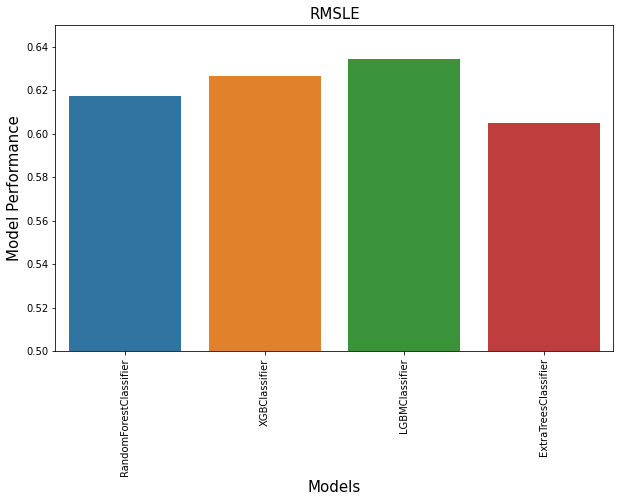

In [ ]:
f, ax = plt.subplots(figsize = (10, 6))
plt.xticks(rotation = '90')
sns.barplot(x = result_df['Model'], y = result_df['Score'])
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Model Performance', fontsize = 15)
plt.ylim(0.5, 0.65)
plt.title('RMSLE', fontsize = 15)
plt.show()

# 4. 데이터 분할 및 모델링 1

In [ ]:
df_train6_1 = df_train4.loc[df_train4['Month'] < 9, :]
df_train6_1.reset_index(drop = True, inplace = True)
X_part_train = df_train6_1.drop('target', axis = 1)
y_part_train = df_train6_1['target']

df_train6_2 = df_train4.loc[(df_train4['Month'] == 9) | (df_train4['Month'] == 10)]
df_train6_2.reset_index(drop = True, inplace = True)
X_val = df_train6_2.drop('target', axis = 1)
y_val = df_train6_2['target']

df_train6_3 = df_train4.loc[df_train4['Month'] == 11]
df_train6_3.reset_index(drop = True, inplace = True)
X_part_test = df_train6_3.drop('target', axis = 1)
y_part_test = df_train6_3['target']

df_train6_4 = df_train4.loc[df_train4['Month'] <= 10]
df_train6_4.reset_index(drop = True, inplace = True)
X_train = df_train6_4.drop('target', axis = 1)
y_train = df_train6_4['target']

X_test = df_test4.copy()

print(X_part_train.shape)
print(y_part_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_part_test.shape)
print(y_part_test.shape)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(368974, 169)
(368974,)
(87998, 169)
(87998,)
(44979, 169)
(44979,)
(456972, 169)
(456972,)
(46404, 169)


In [ ]:
def objective(trial : Trial) -> float :

    params_lgb = {
        "random_state": 39,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": trial.suggest_int('n_estimators', 100, 5000),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500)
    }
    
    model = LGBMClassifier(**params_lgb)
    model.fit(X_part_train, y_part_train, eval_set = [(X_part_train, y_part_train), (X_val, y_val)],
              early_stopping_rounds = 100, verbose = False)

    lgbm_pred = model.predict(X_val)
    f1 = f1_score(y_val, lgbm_pred)
    
    return f1

In [ ]:
sampler = TPESampler(seed = 39)
study = optuna.create_study(
    study_name = "lgbm_parameter_opt",
    direction = "maximize",
    sampler = sampler)
study.optimize(objective, n_trials = 500)

NameError: ignored

In [ ]:
print("Best Score :", study.best_value)
print("Best trial :", study.best_trial.params)

Best Score : 0.6479453077505574
Best trial : {'n_estimators': 1447, 'reg_alpha': 1.9789105242232932, 'reg_lambda': 0.0026602983980182904, 'max_depth': 14, 'num_leaves': 87, 'colsample_bytree': 0.992812938438909, 'subsample': 0.8599496113145693, 'subsample_freq': 10, 'min_child_samples': 41, 'max_bin': 335}


In [ ]:
# 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 파라미터들과의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna_lgbm = LGBMClassifier(
    random_state = 39,
    verbosity = -1,
    learning_rate = 0.05,
    n_estimators = study.best_trial.params['n_estimators'],
    colsample_bytree = study.best_trial.params['colsample_bytree'], 
    max_bin = study.best_trial.params['max_bin'],
    max_depth = study.best_trial.params['max_depth'],
    min_child_samples = study.best_trial.params['min_child_samples'],
    num_leaves = study.best_trial.params['num_leaves'],  
    reg_alpha = study.best_trial.params['reg_alpha'],
    reg_lambda = study.best_trial.params['reg_lambda'],
    subsample = study.best_trial.params['subsample'],
    subsample_freq = study.best_trial.params['subsample_freq'])

optuna_lgbm.fit(X_train, y_train, verbose = False)
optuna_lgbm_train_preds = optuna_lgbm.predict(X_train)
optuna_lgbm_part_test_preds = optuna_lgbm.predict(X_part_test)
f1_train = f1_score(optuna_lgbm_train_preds, y_train)
f1_part_test = f1_score(optuna_lgbm_part_test_preds, y_part_test)
print('f1_train :', f1_train)
print('f1_part_test :', f1_part_test)

f1_train : 0.7559425421410774
f1_part_test : 0.6329058994554014


In [ ]:
# 제출

submission_preds = optuna_lgbm.predict(test_X)
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/sample_submission.csv')
submission['target'] = submission_preds
submission.to_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/submission_lgbm.csv', index = False)

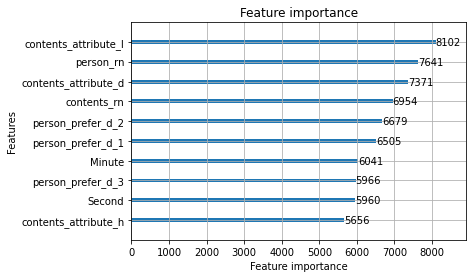

In [ ]:
# (1) 상대중요도

lgb.plot_importance(optuna_lgbm, max_num_features = 10)

In [ ]:
ftr_importances_values = optuna_lgbm.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_importances = ftr_importances.sort_values(ascending = True)

In [ ]:
ftr_importances[ : 20]

h3_all_match_yn_1               0
d3_la_match_yn_0                0
d3_la_match_yn_1                0
d1_all_match_yn_1               0
d1_la_match_yn_1                0
Hour2_dawn                      0
d3_all_match_yn_1               0
person_prefer_d_3_중             0
contents_attribute_j_under_1    0
d2_all_match_yn_1               0
d2_la_match_yn_1                0
h1_all_match_yn_1               0
h2_all_match_yn_1               0
person_attribute_a_2            1
h3_mi_match_yn_1                1
contents_attribute_h_대          1
contents_attribute_d_중          1
d1_la_match_yn_0                1
d1_sm_match_yn_1                1
Hour2_night                     1
dtype: int64

In [ ]:
ftr_importances[140 : ]

contents_attribute_m_1       347
h1_match_FFF                 384
person_prefer_d_3_세          486
contents_attribute_a_1       488
person_prefer_d_2_세          577
contents_attribute_l_소       694
person_prefer_d_1_세          726
contents_attribute_d_세      1163
contents_attribute_l_세      1240
person_attribute_b          1428
contents_attribute_e        2616
person_prefer_e             3015
person_attribute_a_under    3214
Month                       3379
Hour                        4155
person_prefer_h_1           4953
person_prefer_h_3           5171
Day                         5183
person_prefer_h_2           5489
contents_attribute_h        5656
Second                      5960
person_prefer_d_3           5966
Minute                      6041
person_prefer_d_1           6505
person_prefer_d_2           6679
contents_rn                 6954
contents_attribute_d        7371
person_rn                   7641
contents_attribute_l        8102
dtype: int64

# 5. 데이터 분할 및 모델링 2

In [ ]:
df_train4.columns[ : 60]

Index(['person_attribute_a_under', 'person_attribute_b', 'person_prefer_d_1',
       'person_prefer_d_2', 'person_prefer_d_3', 'person_prefer_e',
       'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
       'contents_attribute_l', 'contents_attribute_d', 'contents_attribute_e',
       'contents_attribute_h', 'person_rn', 'contents_rn', 'target',
       'person_prefer_d_1_세', 'person_prefer_d_1_소', 'person_prefer_d_1_중',
       'person_prefer_d_1_대', 'person_prefer_d_2_세', 'person_prefer_d_2_소',
       'person_prefer_d_2_중', 'person_prefer_d_2_대', 'person_prefer_d_3_세',
       'person_prefer_d_3_소', 'person_prefer_d_3_중', 'person_prefer_d_3_대',
       'contents_attribute_d_세', 'contents_attribute_d_소',
       'contents_attribute_d_중', 'contents_attribute_d_대',
       'person_prefer_h_1_중', 'person_prefer_h_1_대', 'person_prefer_h_2_중',
       'person_prefer_h_2_대', 'person_prefer_h_3_중', 'person_prefer_h_3_대',
       'contents_attribute_h_중', 'contents_attribute_h_대',
   

In [ ]:
df_train4.columns[60 : 120]

Index(['d1_match_TTTFF', 'd1_match_TTTTF', 'd1_match_TTTTT', 'd2_match_FFFFF',
       'd2_match_TFFFF', 'd2_match_TTFFF', 'd2_match_TTTFF', 'd2_match_TTTTF',
       'd2_match_TTTTT', 'd3_match_FFFFF', 'd3_match_TFFFF', 'd3_match_TTFFF',
       'd3_match_TTTFF', 'd3_match_TTTTF', 'd3_match_TTTTT', 'h1_match_FFF',
       'h1_match_TFF', 'h1_match_TTF', 'h1_match_TTT', 'h2_match_FFF',
       'h2_match_TFF', 'h2_match_TTF', 'h2_match_TTT', 'h3_match_FFF',
       'h3_match_TFF', 'h3_match_TTF', 'h3_match_TTT', 'person_attribute_a_1',
       'person_attribute_a_2', 'person_prefer_c_1', 'person_prefer_c_2',
       'person_prefer_c_3', 'person_prefer_c_4', 'person_prefer_c_5',
       'contents_attribute_i_1', 'contents_attribute_i_2',
       'contents_attribute_i_3', 'contents_attribute_a_1',
       'contents_attribute_a_2', 'contents_attribute_a_3',
       'contents_attribute_j_under_1', 'contents_attribute_j_under_2',
       'contents_attribute_j_under_3', 'contents_attribute_j_under_4',
   

In [ ]:
df_train4.columns[120 :]

Index(['contents_attribute_m_4', 'contents_attribute_m_5', 'd1_la_match_yn_0',
       'd1_la_match_yn_1', 'd1_mi_match_yn_0', 'd1_mi_match_yn_1',
       'd1_sm_match_yn_0', 'd1_sm_match_yn_1', 'd1_sub_match_yn_0',
       'd1_sub_match_yn_1', 'd1_all_match_yn_0', 'd1_all_match_yn_1',
       'd2_la_match_yn_0', 'd2_la_match_yn_1', 'd2_mi_match_yn_0',
       'd2_mi_match_yn_1', 'd2_sm_match_yn_0', 'd2_sm_match_yn_1',
       'd2_sub_match_yn_0', 'd2_sub_match_yn_1', 'd2_all_match_yn_0',
       'd2_all_match_yn_1', 'd3_la_match_yn_0', 'd3_la_match_yn_1',
       'd3_mi_match_yn_0', 'd3_mi_match_yn_1', 'd3_sm_match_yn_0',
       'd3_sm_match_yn_1', 'd3_sub_match_yn_0', 'd3_sub_match_yn_1',
       'd3_all_match_yn_0', 'd3_all_match_yn_1', 'h1_la_match_yn_0',
       'h1_la_match_yn_1', 'h1_mi_match_yn_0', 'h1_mi_match_yn_1',
       'h1_all_match_yn_0', 'h1_all_match_yn_1', 'h2_la_match_yn_0',
       'h2_la_match_yn_1', 'h2_mi_match_yn_0', 'h2_mi_match_yn_1',
       'h2_all_match_yn_0', 'h2_all_

In [ ]:
df_train6_1 = df_train4.loc[df_train4['Month'] < 9, :]
df_train6_1.reset_index(drop = True, inplace = True)
X_part_train = df_train6_1.drop('target', axis = 1)
y_part_train = df_train6_1['target']

df_train6_2 = df_train4.loc[(df_train4['Month'] == 9) | (df_train4['Month'] == 10)]
df_train6_2.reset_index(drop = True, inplace = True)
X_val = df_train6_2.drop('target', axis = 1)
y_val = df_train6_2['target']

df_train6_3 = df_train4.loc[df_train4['Month'] == 11]
df_train6_3.reset_index(drop = True, inplace = True)
X_part_test = df_train6_3.drop('target', axis = 1)
y_part_test = df_train6_3['target']

df_train6_4 = df_train4.loc[df_train4['Month'] <= 10]
df_train6_4.reset_index(drop = True, inplace = True)
X_train = df_train6_4.drop('target', axis = 1)
y_train = df_train6_4['target']

X_test = df_test4.copy()

print(X_part_train.shape)
print(y_part_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_part_test.shape)
print(y_part_test.shape)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

# 6. 결과 분석